# Что я хочу?

Я хочу написать классификатор вина(хорошее/плохое), используя:
* Рассмотреть target и взаимосвязь переменных с таргетом - 1 томат
* FeatureEngeenering, чтобы получить новые фичи. Но только не рандомно тыкаться носом, а смотреть на mi score. - 6 томатов
* Разделение на тренировочные и тестовые, но убедиться, что все классы присутсвуют в обоих выборках - 2 томата
* Удаление Выбросов, при помощи высчисления выбросов в столбцах(тестовые) - 2 томата
* Box-Cox трансформацию в сравнениии с логарифмической трансформацией на скошенных вправо данных(тестовые и тренировочные) - 3 томата
* Удаление ненужных фич(тренировочные и тестовые) - 2 томата
* resampling(тренировочные) - 1 томат
* Тестирование различных моделей - 4 томата

# Импорт модулей

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from scipy import stats

import warnings
warnings.filterwarnings("ignore")
np.random.seed(100)

In [2]:
df_main = pd.read_csv('data/winequality-red.csv')
df_main.columns = list(map(lambda x: x.replace(' ', '_'), df_main.columns))
df_main

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df_features = df_main.copy()

# Рассматриваем target и взаимосвязь переменных с ним

<AxesSubplot:xlabel='quality', ylabel='count'>

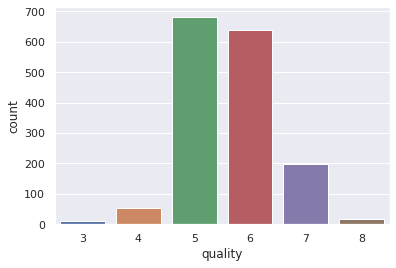

In [4]:
sns.countplot(x=df_main['quality'])

In [5]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

<AxesSubplot:>

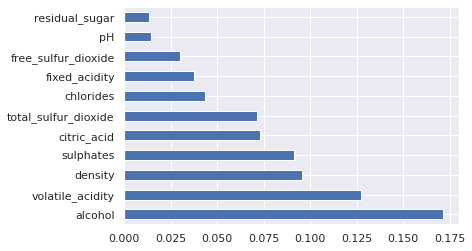

In [6]:
mi_score = make_mi_scores(df_main.drop('quality', axis=1), df_main['quality'])
mi_score.plot(kind='barh')

In [7]:
def plot_correlation_heatmap(df, figsize=(6, 6), abs_flag=True, ax=None):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()


    corr_matr = df.corr()
    if abs_flag:
        corr_matr = corr_matr.abs()
    corr_matr[corr_matr == 1] = 0
    sns.heatmap(corr_matr, square=True, annot=True, cmap='YlGnBu', ax=ax)

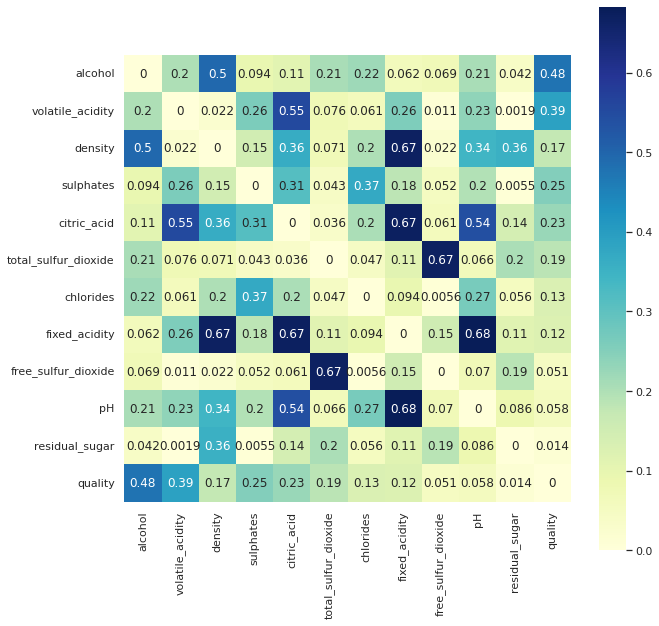

In [8]:
plot_correlation_heatmap(df_main[mi_score[:].index.to_list() + ['quality']],
                         (10, 10))

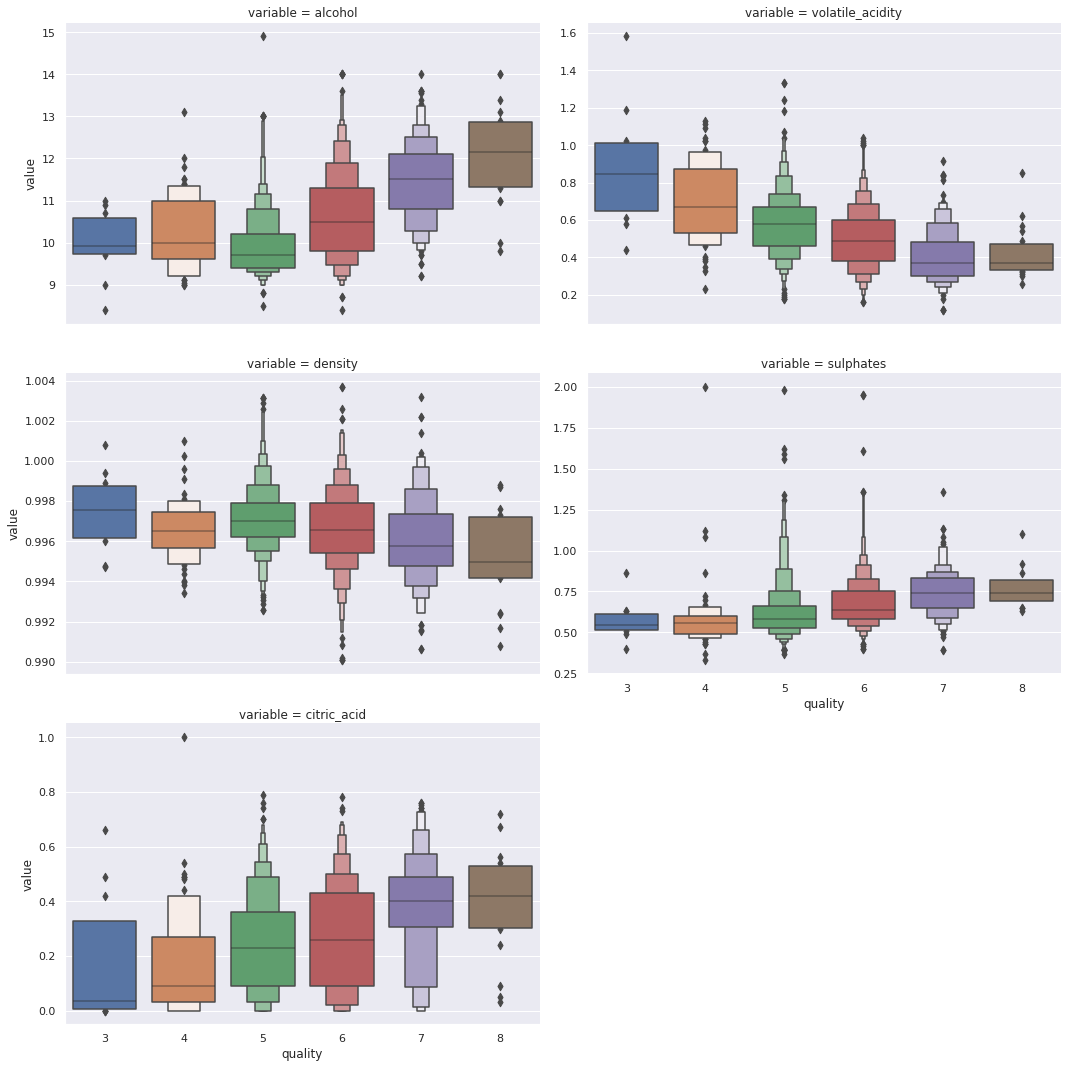

In [9]:
cols = mi_score[:5].index.to_list()
sns.catplot(data=df_main.melt('quality', cols),
            x='quality', y='value',  col='variable', col_wrap=2, sharey=False, kind='boxen', aspect=1.5)

Выводы:
* Alcohol с density
* volatile_acidity сильно коррелирует с citric_acid, от остальных он стоит особняком
* density с alcohol и fixed_acidity
* citric acid со всеми остальными кислотными показателями
* total sulfur dioxid с free
* fixed acidity со всеми остальными кислотными показателями кроме volatile
* pH слабо коррелирует с volatile_acidity
* chlorides и sulphates стоят особняком как черные кардиналы, причем они взаимосвязаны между собой

План действий:
* Изучить корреляцию alcohol с density
* Понять почему volatile_acidity стоит особняком и понять как при помощи него можно сделать полезные фичи
* density и fixed_acidity - сильная корреляция. Понять в чем химическая подоплека
* Найти взаимосвязь между chlorides и sulphates, понять как их можно использовать
* Фича residual_sugar - бесполезна. Как при помощи нее можно создать нечто интересное/полезное? Или может просто откинем ее?
* free_sulfur_dioxide и total_sulfur_dioxide, что мы можем найти полезного?

#  Углубленный анализ

In [10]:
acid_cols = ['volatile_acidity', 'citric_acid', 'fixed_acidity', 'pH']

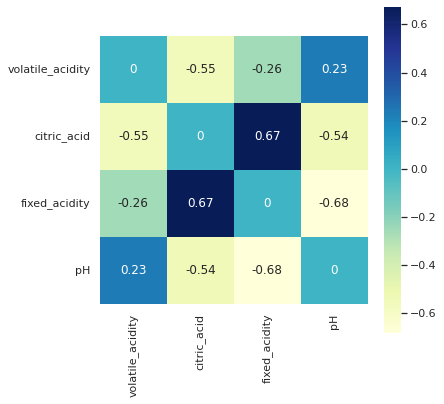

In [11]:
plot_correlation_heatmap(df_main[acid_cols], figsize=(6, 6), abs_flag=False)

## Почему volatile имеет положительную корреляцию с pH

Можно заметить, что volatile_acidity увеличивает pH, то есть уменьшает кислотность, что очень странно

Может деле в том, что volatile_acidity слишком мало и ее изменение не вляет на pH?

In [12]:
df_main[acid_cols].describe()

,volatile_acidity,citric_acid,fixed_acidity,pH
count,1599.000000,1599.000000,1599.000000,1599.000000
mean,0.527821,0.270976,8.319637,3.311113
std,0.179060,0.194801,1.741096,0.154386
min,0.120000,0.000000,4.600000,2.740000
25%,0.390000,0.090000,7.100000,3.210000
50%,0.520000,0.260000,7.900000,3.310000
75%,0.640000,0.420000,9.200000,3.400000
max,1.580000,1.000000,15.900000,4.010000


Как мы видим citric_acidity еще меньше, но она коррелирует с pH

Может тогда volatile_acidity само по себе имеет небольшую кислотность?

Оказывается, что volatile acidity - это множество разнообразных кислот, но почему оно положительно коррелирует с pH так и не удалось выяснить

Рассмотрим volatile и pH в зависимости от quality

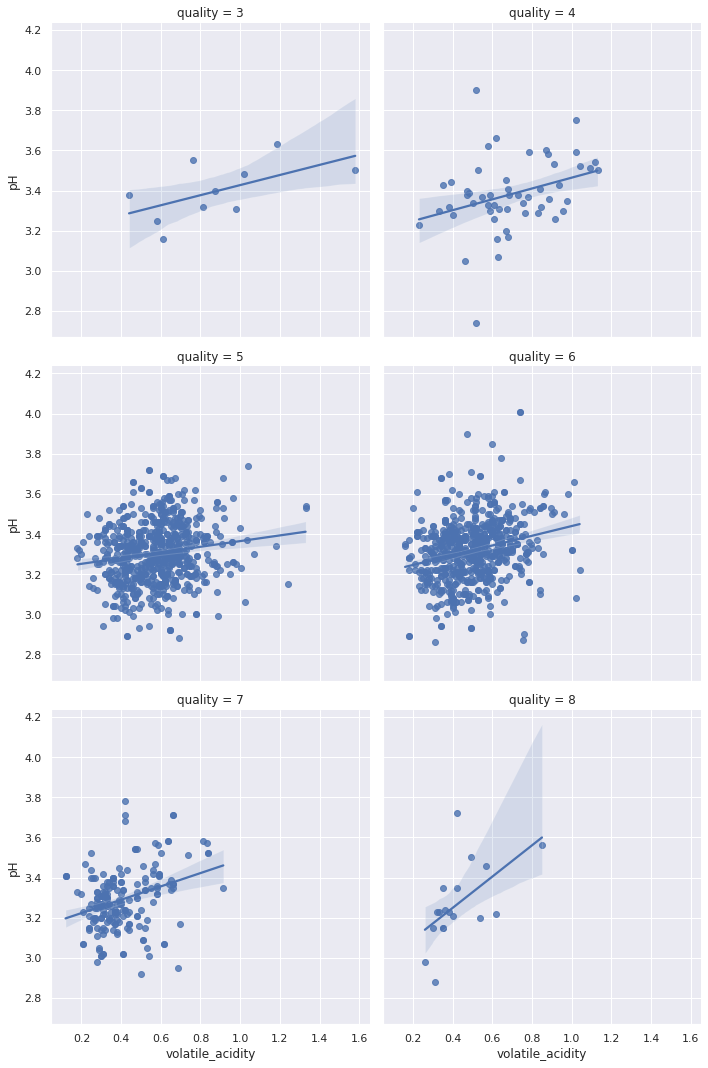

In [13]:
sns.lmplot(data=df_main, x='volatile_acidity', y='pH', col='quality', col_wrap=2)

Разницу в распределении найти не удалось

А что если увязать volatile, fixed и pH. Может взаимосвязь volatile и fixed выливает в pH?

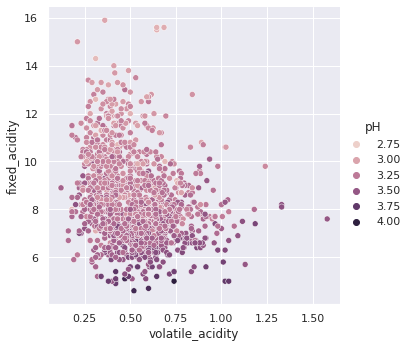

In [14]:
sns.relplot(data=df_main, x='volatile_acidity', y='fixed_acidity', hue='pH')

Видно лишь то, что fixed_acidity влияет на pH и все. Больше ничего интересного

Вывод: ничего интересного в положительной корреляйции pH и volatile_acidity найти не удалось

## volatile и остальные кислоты

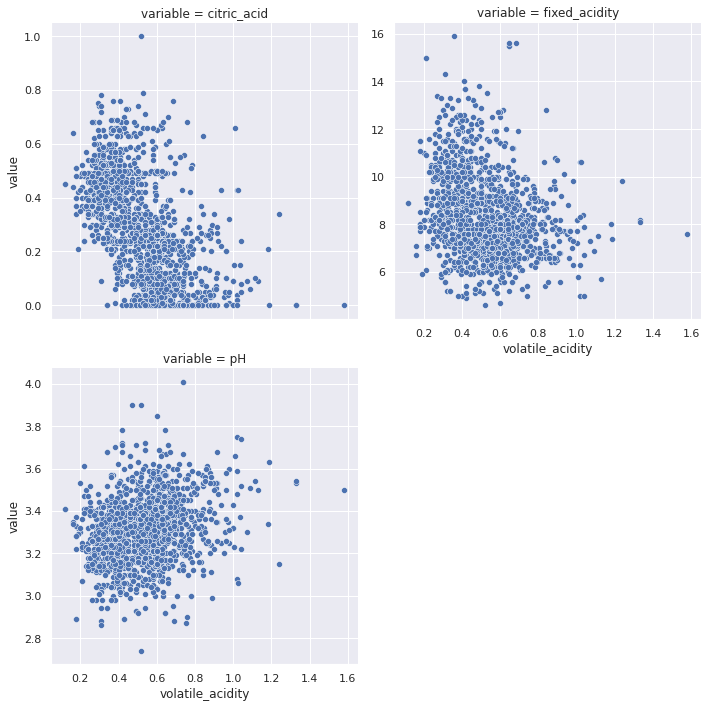

In [15]:
tmp = acid_cols.copy()
tmp.remove('volatile_acidity')
melted = df_main.melt('volatile_acidity',  tmp)
sns.relplot(data=melted, x='volatile_acidity', y='value',
            col='variable', col_wrap=2, facet_kws={'sharey': False})

Пытаюсь найти какие соотношения хорошо коррелериют с оценкой

In [16]:
cols = df_main[['citric_acid', 'fixed_acidity', 'pH']]
div = df_main['volatile_acidity']
ratios = cols.div(div, axis=0)
ratios = pd.concat([df_main['quality'],  ratios], axis=1)


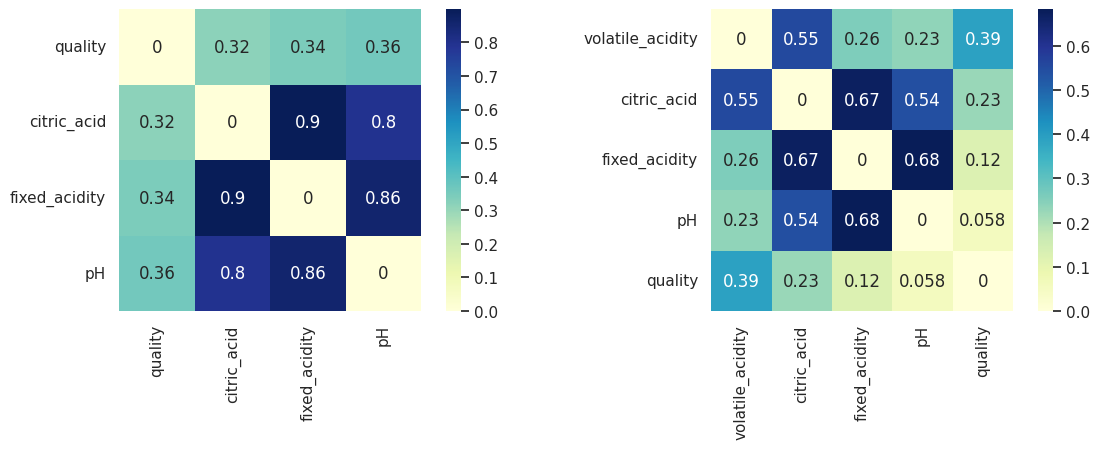

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
plot_correlation_heatmap(ratios, abs_flag=False, ax=axis[0])
plot_correlation_heatmap(df_main[acid_cols+['quality']], ax=axis[1])

Соотношение volatile с остальными кислотными показателями дало улучшенную корреляцию с качеством, но это можно списать на то, что сам по себе volatile сильно коррелирует с quality.
Увеличение корреляции pH с quality:
* volatile с ph может быть интересным

Также деление на volatile увеличило корреляцию:
* fixed citrc 0.67 -> 0.9
* fixed pH 0.68 -> 0.9
* citric pH 0.54 -> 0.8

### Полезны ли соотношения как фичи

In [18]:
tmp_df = df_main.copy()

tmp_df['citric/vol'] = df_main['citric_acid'] /  df_main['volatile_acidity']
tmp_df['fixed/vol'] = df_main['fixed_acidity'] /  df_main['volatile_acidity']
tmp_df['pH/vol'] = df_main['pH'] /  df_main['volatile_acidity']
tmp_df['1/vol'] = 1 / tmp_df['volatile_acidity']
# Приводим к одинаковой размерности
# cols = acid_cols.copy()
# cols.remove('volatile_acidity')
# tmp_df[cols] *= 1/tmp_df['volatile_acidity'].mean()

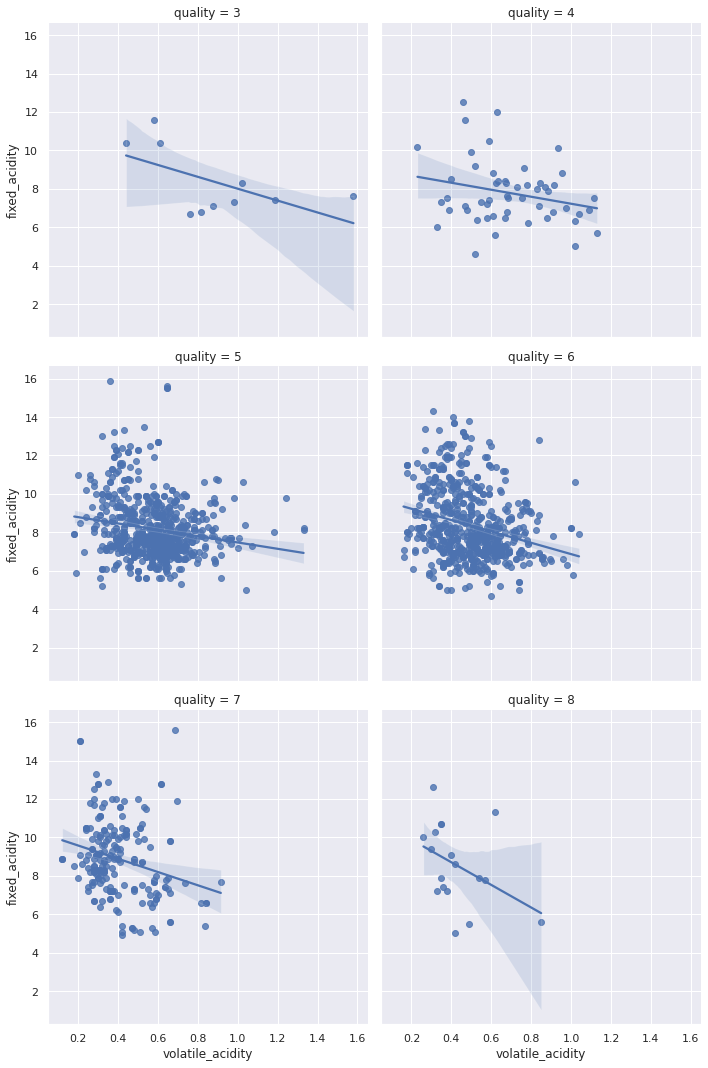

In [19]:
sns.lmplot(data=df_main, x='volatile_acidity', y='fixed_acidity', col='quality', col_wrap=2)

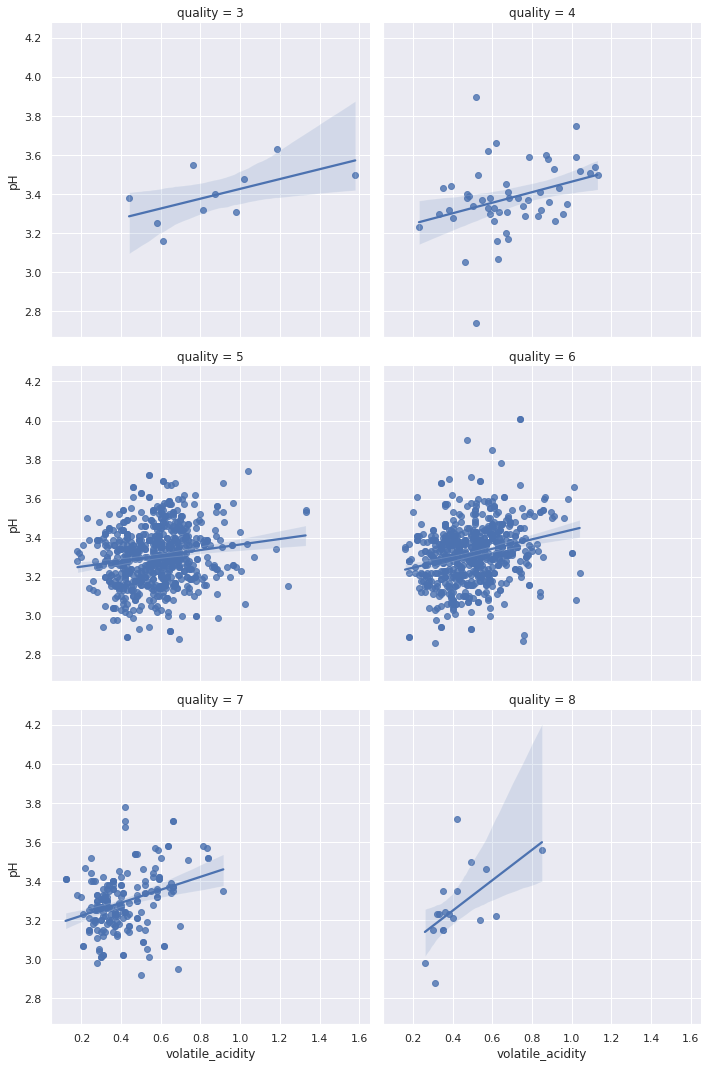

In [20]:
sns.lmplot(data=df_main, x='volatile_acidity', y='pH', col='quality', col_wrap=2)

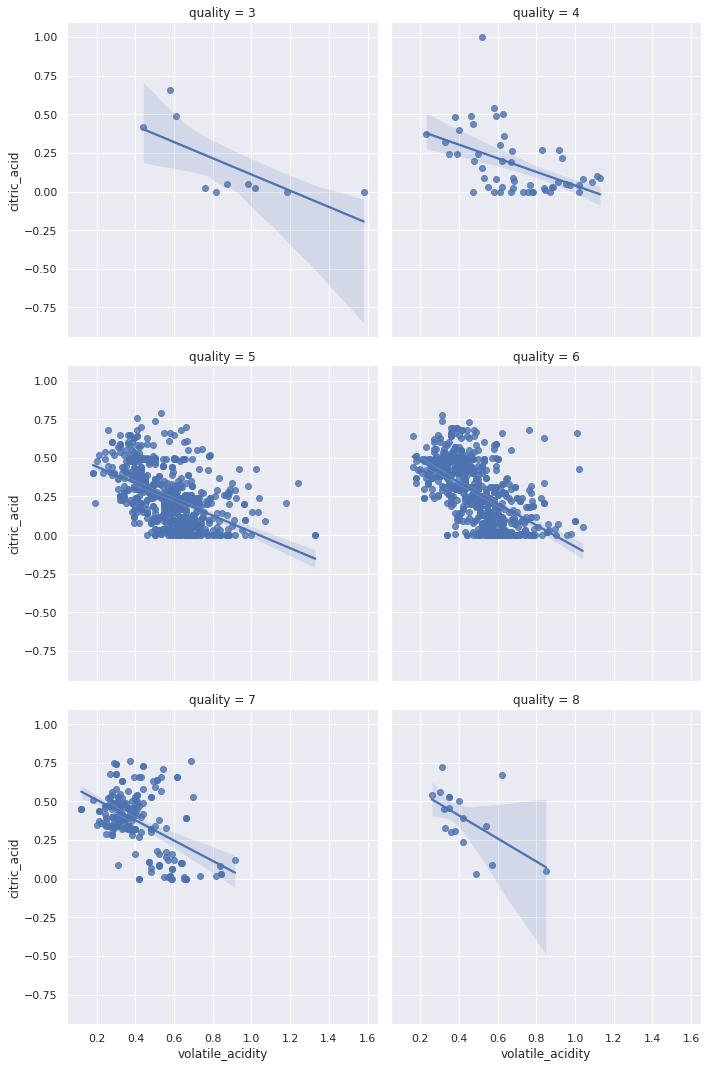

In [21]:
sns.lmplot(data=df_main, x='volatile_acidity', y='citric_acid', col='quality', col_wrap=2)

Вывод: ни одно соотношение не полезно

### Исследование сильных корреляций

<AxesSubplot:xlabel='citric/vol', ylabel='fixed/vol'>

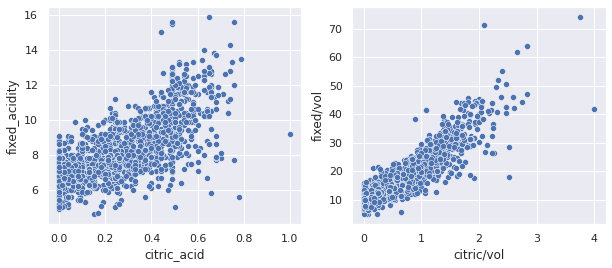

In [22]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

sns.scatterplot(data=tmp_df, x='citric_acid', y='fixed_acidity', ax=axis[0])
sns.scatterplot(data=tmp_df, x='citric/vol', y='fixed/vol', ax=axis[1])

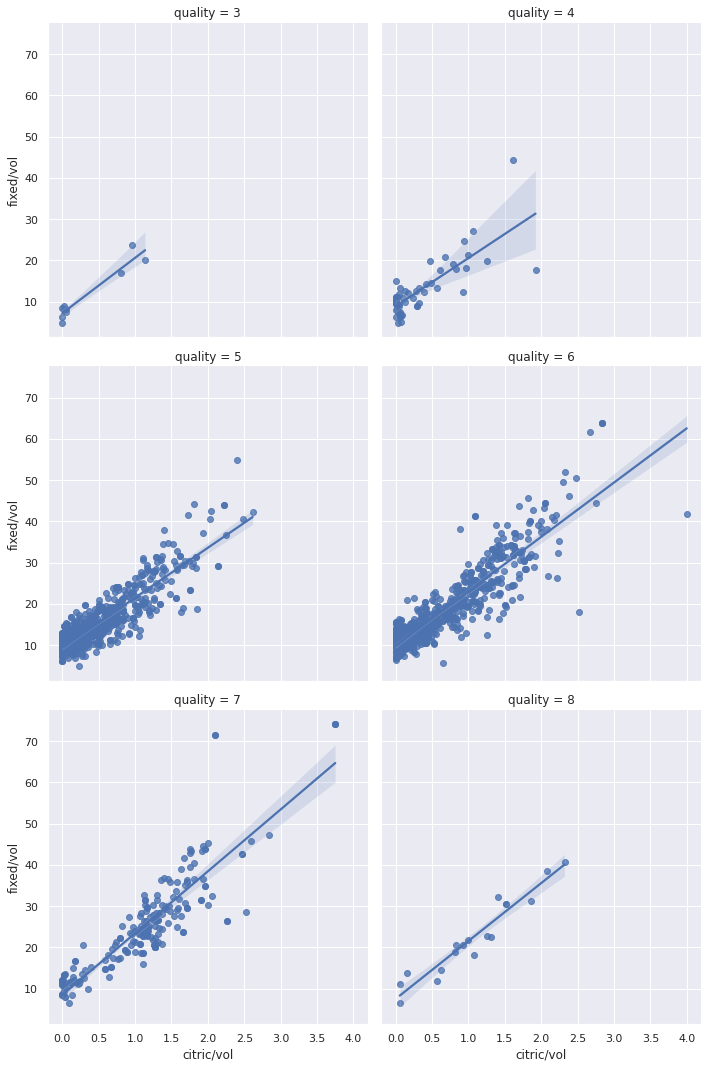

In [23]:
sns.lmplot(data=tmp_df, x='citric/vol', y='fixed/vol', col='quality', col_wrap=2)

Вывод: у нас получились сильные корреляции независимых переменных между собой, но это ничего особо не значит, также увеличение корреляции с качеством вследствие деления списывается на простое наличие сильной корреляции с

## А что будет если забинить pH?

<AxesSubplot:xlabel='quality', ylabel='pH'>

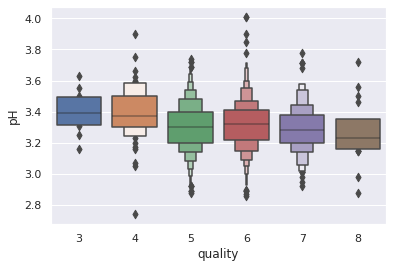

In [24]:
sns.boxenplot(data=df_main, x='quality', y='pH')

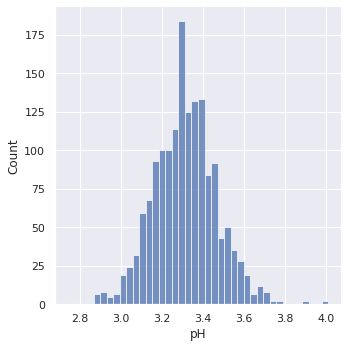

In [25]:
sns.displot(df_main['pH'])

In [26]:
tmp_df  = df_main.copy()
tmp_df['pH_bin'] = pd.cut(df_main['pH'], 5, labels=['1', '2', '3' ,'4', '5'])

In [27]:
percentage_df = pd.DataFrame()
qualities = []
pH_bins = []
percentages = []
for quality in range(3, 9):
    df_with_quality = tmp_df[df_main['quality'] == quality]
    for pH_bin in map(str, range(1, 6)):
        qualities.append(quality)
        pH_bins.append(pH_bin)
        percentage = (df_with_quality['pH_bin'] == pH_bin).sum() / len(df_with_quality)
        percentages.append(percentage)
percentage_df['quality'] = qualities
percentage_df['pH_bin'] = pH_bins
percentage_df['percent'] = percentages


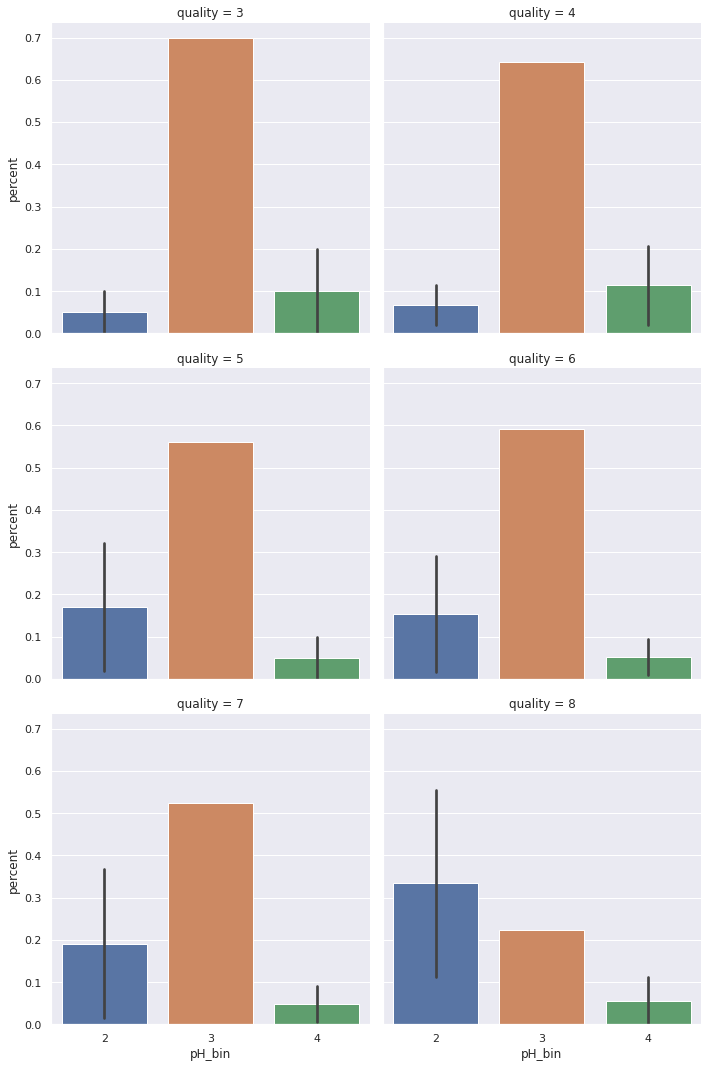

In [28]:
map_dict = {'1': '2', '5': '4', '3':'3'}
percentage_df['pH_bin'] = percentage_df['pH_bin'].replace(map_dict)
sns.catplot(data=percentage_df, x='pH_bin', y='percent',
            kind='bar', col='quality' ,col_wrap=2)

In [29]:
tmp_df['pH_bin'] = tmp_df['pH_bin'].replace(map_dict)
gnb = KNeighborsClassifier(n_neighbors=12)
cross_validate(gnb, tmp_df[['pH_bin']], tmp_df['quality'])['test_score'].mean()

0.43278800940438866

In [30]:
cross_validate(gnb, tmp_df[['pH']], tmp_df['quality'])['test_score'].mean()

0.4164949059561128

Вывод: так как pH_bin - это хорошая категориальная фича, то мы заменим ей pH

# Анализируем алкоголь

## Проверим все соотношения

Метрика соотношения: если std наклона прямой в зависимости от класса больше определенного значения, то вывести эту пару

In [31]:
df_main.columns.to_list()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [32]:
pairs = []
columns = df_main.columns.to_list()
model = Pipeline([('transformer', StandardScaler()), ('estimator', linear_model.LinearRegression())])

for ind1, col1 in enumerate(columns):
    for col2 in columns[ind1+1:]:
        coefs = df_main.groupby('quality').apply(
            lambda df: model.fit(df[[col1]], df[col2])['estimator'].coef_[0]
        )
        if coefs.std() > 5:
            pairs.append((col1, col2))
pairs

[('fixed_acidity', 'total_sulfur_dioxide'),
 ('volatile_acidity', 'total_sulfur_dioxide'),
 ('citric_acid', 'total_sulfur_dioxide'),
 ('residual_sugar', 'total_sulfur_dioxide'),
 ('chlorides', 'total_sulfur_dioxide')]

In [33]:
def show_ratios(i):
    sns.lmplot(data=df_main, x=pairs[i][0],  y=pairs[i][1], col_wrap=2, col='quality')

Проанализировав соотношения мы можем заметить, что все соотношения полезны

## Кластеризация как фича

### Попробуем посоздовать различные кластеры, используя 2 кислотные переменные

In [34]:
def create_kmeans_pipe(n_clusters):
    return Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=n_clusters))])

In [35]:
tmp_df = df_main.copy()
clustering_result = pd.DataFrame(columns=['col1', 'col2', 'n_clusters', 'mi_score'])
for ind1, col1 in enumerate(acid_cols):
    for col2 in acid_cols[ind1+1:]:
        best_n_clusters = 0
        best_mi_score = -1
        for n_clusters in [5, 8, 10]:
            kmeans = create_kmeans_pipe(n_clusters)
            tmp_df['clusters'] = kmeans.fit_predict(tmp_df[[col1, col2]])
            tmp_df['clusters'] = tmp_df['clusters'].astype(str)
            mi = make_mi_scores(tmp_df[['clusters']], tmp_df['quality']).iloc[0]
            if mi > best_mi_score:
                best_mi_score = mi
                best_n_clusters = n_clusters
        result = {'col1': col1, 'col2': col2,
                  'n_clusters': best_n_clusters, 'mi_score': best_mi_score}
        clustering_result = clustering_result.append(result, ignore_index=True)


In [36]:
clustering_result

,col1,col2,n_clusters,mi_score
0,volatile_acidity,citric_acid,8,0.106487
1,volatile_acidity,fixed_acidity,8,0.099909
2,volatile_acidity,pH,8,0.09397
3,citric_acid,fixed_acidity,10,0.043003
4,citric_acid,pH,8,0.069798
5,fixed_acidity,pH,10,0.023548


Вывод: кластеризация полезна. Оставим ее

# Разделение на train и test

In [37]:
df_train, df_test = train_test_split(df_main, train_size=0.8)

In [38]:
sorted(df_train['quality'].unique()) == sorted(df_test['quality'].unique())

True

Разделение попалось удачным и у нас есть все классы в обоих выборках

# Отфильтруем выбросы в тренировочных данных

Фильтровать будем опираясь на

План: если в столбец имеется 2 и более отклонения на 3 стандартных отклонения, то выбрасываем строку

In [39]:
X_train = df_train.drop('quality', axis=1)
X_train_norm = pd.DataFrame(np.abs(StandardScaler().fit_transform(X_train)),
                             columns=X_train.columns,
                             index=X_train.index)
mask = np.sum(X_train_norm > 3, axis=1) >= 2
np.sum(mask)

26

In [40]:
df_train.drop(df_train[mask].index, inplace=True)

## Попробовать использовать PCA для поиска выбросов

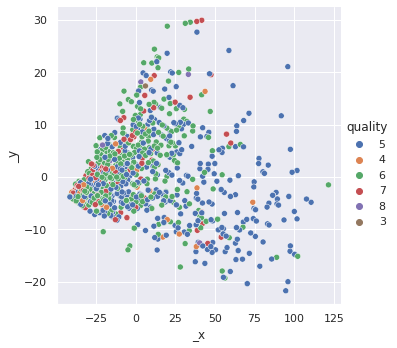

In [41]:
X_train = df_train.drop('quality', axis=1)
pca = PCA(n_components=2)
components = pca.fit_transform(X_train)
sns.relplot(x=components[:, 0], y=components[:, 1], hue=df_train['quality'].astype('str'))

Вывод: не видно каких-либо выбосов

## Используем кластеризацию

In [42]:
from sklearn.mixture import BayesianGaussianMixture

Выявляем по 5 процентов выбросов для качества 5, 6, 7 и удаляем их

In [43]:
outlier_indexes = {}
bgm = BayesianGaussianMixture(n_components=4)
for quality in [5, 6, 7]:
    df_quality = df_train[df_train['quality'] == quality]
    bgm.fit(df_quality)
    densities = bgm.score_samples(df_quality)
    density_threshhold = np.percentile(densities, 5)
    anomaly_indexes = df_quality[densities < density_threshhold].index
    df_train.drop(anomaly_indexes, inplace=True)

In [44]:
len(df_train)

1192

# FeatureEngenering

df_main мы не трогаем. Создадим df_combined, в котором будет находиться как тестовые, так и тренировочные

In [45]:
df_combined = pd.concat([df_train, df_test])

pairs = [('fixed_acidity', 'total_sulfur_dioxide'),
         ('volatile_acidity', 'total_sulfur_dioxide'),
         ('citric_acid', 'total_sulfur_dioxide'),
         ('residual_sugar', 'total_sulfur_dioxide')]


for col1, col2 in pairs:
    df_combined[f'{col1}/{col2}'] =df_combined[col1]/df_combined[col2]

df_combined['pH_bin'] = pd.cut(df_combined['pH'], 5, labels=list(range(5)))
df_combined['pH_bin'] = df_combined['pH_bin'].astype(str)
map_dict = {'0': '1',  '4': '3'}
df_combined['pH_bin'] = df_combined['pH_bin'].replace(map_dict)


clustering_pairs = [['volatile_acidity', 'fixed_acidity'], ['volatile_acidity', 'citric_acid'], ['volatile_acidity', 'pH']]


n_cluster = 8
model = create_kmeans_pipe(8)
for id, col_pair in enumerate(clustering_pairs):
    model.fit(df_train[col_pair])
    clusters = model.predict(df_combined[col_pair])
    clusters = clusters.astype(str)
    df_combined[f'clustering_{id}'] = clusters


In [46]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 457 to 1483
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   fixed_acidity                          1512 non-null   float64
 1   volatile_acidity                       1512 non-null   float64
 2   citric_acid                            1512 non-null   float64
 3   residual_sugar                         1512 non-null   float64
 4   chlorides                              1512 non-null   float64
 5   free_sulfur_dioxide                    1512 non-null   float64
 6   total_sulfur_dioxide                   1512 non-null   float64
 7   density                                1512 non-null   float64
 8   pH                                     1512 non-null   float64
 9   sulphates                              1512 non-null   float64
 10  alcohol                                1512 non-null   float64
 11  qu

# Нормализация переменных

Ищем все переменные у которых skew отклоняется больше чем на 1, делаем для них boxcox и сравниваем qq плоты до и после

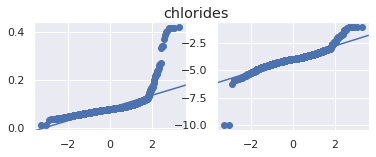

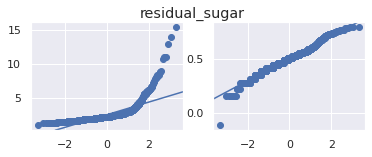

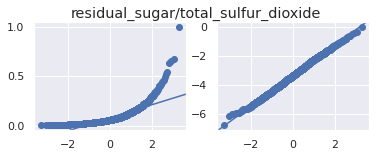

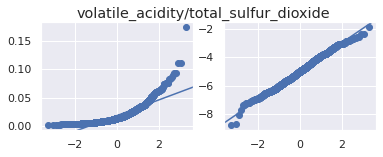

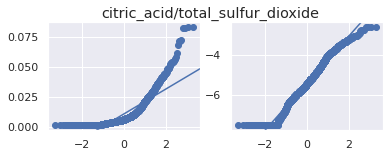

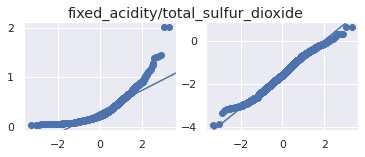

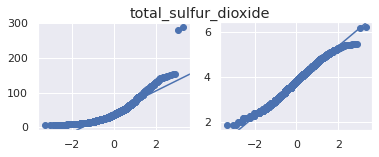

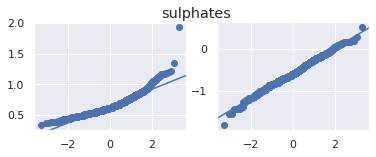

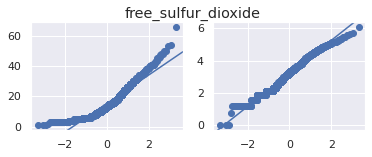

In [47]:
skews = df_combined._get_numeric_data().skew()
skews.sort_values(ascending=False, inplace=True)
skewed_cols = skews[skews.abs() > 1].index
for col in skewed_cols:
    fig, axis = plt.subplots(1, 2, figsize=(6, 2))
    fig.suptitle(col)
    before = df_combined[col]
    before_min = before.min()
    if before_min <= 0:
        before -= (before_min - 0.001)
    after = stats.boxcox(before)[0]
    x, (slope, intercept, _) = stats.probplot(before)
    axis[0].scatter(x[0], x[1])
    axis[0].axline([0, intercept], slope=slope)
    x, (slope, intercept, _) = stats.probplot(after)
    axis[1].scatter(x[0], x[1])
    axis[1].axline([0, intercept], slope=slope)

В целом,  все стало выглядеть лучше

In [48]:
for col in skewed_cols:
    df_combined[col] = stats.boxcox(df_combined[col])[0]
df_combined

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,fixed_acidity/total_sulfur_dioxide,volatile_acidity/total_sulfur_dioxide,citric_acid/total_sulfur_dioxide,residual_sugar/total_sulfur_dioxide,pH_bin,clustering_0,clustering_1,clustering_2
457,9.2,0.630,0.21,0.581824,-3.511920,4.538469,4.477121,0.99880,3.28,-0.684638,9.6,5,-2.052563,-5.454500,-5.839836,-3.974983,1,6,5,0
73,8.3,0.675,0.26,0.492253,-3.829850,2.957618,4.005825,0.99760,3.31,-0.830000,9.2,4,-1.713516,-4.803477,-5.261764,-3.728805,1,3,5,3
1337,6.0,0.500,0.00,0.277119,-4.765605,3.435476,3.440618,0.99448,3.36,-1.122537,9.5,5,-1.520664,-4.535743,-7.513068,-3.582900,2,4,7,5
479,9.4,0.685,0.11,0.581824,-4.029543,2.093145,3.637149,0.99840,3.19,-0.413511,10.1,6,-1.229092,-4.354650,-5.757378,-2.891738,1,3,0,0
152,7.5,0.600,0.03,0.422437,-3.557024,4.279302,4.963705,0.99500,3.35,-0.798982,10.1,5,-2.751593,-6.109372,-7.201659,-5.318953,2,1,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,9.1,0.640,0.23,0.620750,-3.557024,3.211881,3.866077,0.99980,3.28,-0.658251,9.7,5,-1.480898,-4.710247,-5.260786,-2.983184,1,6,5,0
376,11.5,0.450,0.50,0.612083,-3.999567,3.816905,4.106737,1.00030,3.26,0.100073,11.0,6,-1.457828,-5.471296,-4.700047,-3.333285,1,7,4,5
996,5.6,0.660,0.00,0.510921,-3.750921,1.207396,2.495811,0.99378,3.71,-0.560318,12.8,7,-0.686495,-3.101876,-7.513068,-1.798001,3,1,0,7
298,7.2,0.650,0.02,0.527816,-3.580052,1.849999,3.637149,0.99930,3.67,-0.244571,9.7,5,-1.513752,-4.422816,-6.928998,-3.117216,3,1,0,7


In [49]:
df_train = df_combined.iloc[:len(df_train)]
df_test = df_combined.iloc[len(df_train):]

# План

сначала я бы хотел:
* Сделать resampling
* Ввести грамотную метрику, по которой буду ориентироваться
* Протестировать различные алгоритмы и понять, какой из них лучше подходит
* Попробовать отобрать фичи и посмотреть на результаты поведения алгоритмов

# Resampling

In [50]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [51]:
X_train_engeneered = df_train.drop('quality', axis=1)
X_train_engeneered  = pd.get_dummies(X_train_engeneered )
y_train_engeneered = df_train['quality']

X_test_engeneered = df_test.drop('quality', axis=1)
X_test_engeneered = pd.get_dummies(X_test_engeneered)
y_test_engeneered =  df_test['quality']


In [52]:
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(df_main.drop('quality', axis=1), df_main['quality'], train_size=0.8)

# Сравним поведение отобранных и стандартных фич на моделях

## Полезные ф-ции

In [53]:
def train_grid(grid_func,  X_train, X_test, y_train, y_test):
    grid = grid_func(X_train, y_train)
    print(f'test accuracy:{grid.score(X_test, y_test)}')
    print(f'train accuracy: {grid.score(X_train, y_train)}')
    return grid

In [54]:
def get_grid_trainig_result(grid):
    result = pd.DataFrame(grid.cv_results_)
    stay_columns = result.filter(regex='param_*').columns[:-1].tolist()
    stay_columns += ['mean_test_score', 'rank_test_score']
    result = result[stay_columns]
    result.sort_values(by='rank_test_score', inplace=True)
    return result

In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import  GaussianNB
import xgboost as xgb

## KNeighbors

In [56]:
def train_kneighbors(X_train, y_train):
    model = imbpipeline([('smote', SMOTE(random_state=14)),
                         ('scaler', StandardScaler()),
                         ('est', KNeighborsClassifier())])
    parameters = {'est__n_neighbors': list(range(1, 20)),
                  'est__weights': ['uniform', 'distance']}
    grid = GridSearchCV(model, parameters, cv=10, error_score="raise")
    grid.fit(X_train, y_train)
    return grid

Неподготовленные данные


In [57]:
grid = train_grid(train_kneighbors,
                  X_train_def, X_test_def,
                  y_train_def, y_test_def)
get_grid_trainig_result(grid)

test accuracy:0.615625
train accuracy: 1.0


,param_est__n_neighbors,param_est__weights,mean_test_score,rank_test_score
0,1,uniform,0.593449,1
1,1,distance,0.593449,1
3,2,distance,0.593449,1
7,4,distance,0.570786,4
5,3,distance,0.560593,5
11,6,distance,0.557480,6
13,7,distance,0.551999,7
19,10,distance,0.549656,8
9,5,distance,0.548105,9
15,8,distance,0.548099,10


Подготовленные данные

In [58]:
grid = train_grid(train_kneighbors,
                  X_train_engeneered, X_test_engeneered,
                  y_train_engeneered, y_test_engeneered)
get_grid_trainig_result(grid)

test accuracy:0.528125
train accuracy: 1.0


,param_est__n_neighbors,param_est__weights,mean_test_score,rank_test_score
5,3,distance,0.608228,1
0,1,uniform,0.605770,2
1,1,distance,0.605770,2
3,2,distance,0.605770,2
7,4,distance,0.605693,5
33,17,distance,0.593144,6
13,7,distance,0.592304,7
9,5,distance,0.591422,8
11,6,distance,0.588936,9
23,12,distance,0.588081,10


Вывод: странно, что средние результаты кроссвалидации у обработанных данных значительно лучше, чем тестовый результат

## RandomForest

In [59]:
def train_random_forest(X_train, y_train):
    model = imbpipeline([('smote', SMOTE(random_state=14)),
                         ('est', RandomForestClassifier())])
    parameters = {'est__max_depth': [10, 20, 22, 25]}
    grid = GridSearchCV(model, parameters, cv=10, error_score="raise")
    grid.fit(X_train, y_train)
    return grid


In [60]:
grid = train_grid(train_random_forest,
                  X_train_def, X_test_def,
                  y_train_def, y_test_def)
get_grid_trainig_result(grid)

test accuracy:0.675
train accuracy: 1.0


,param_est__max_depth,mean_test_score,rank_test_score
1,20,0.637260,1
3,25,0.624723,2
2,22,0.624711,3
0,10,0.604423,4


In [61]:
grid = train_grid(train_random_forest,
                  X_train_engeneered, X_test_engeneered,
                  y_train_engeneered, y_test_engeneered)
get_grid_trainig_result(grid)

test accuracy:0.6125
train accuracy: 1.0


,param_est__max_depth,mean_test_score,rank_test_score
2,22,0.674496,1
1,20,0.673683,2
3,25,0.670273,3
0,10,0.661078,4


Выводы:
* Опять тестовый результат в разы хуже чем кроссвалидациоонный у обработанных данных
* Необработанные данные показывают себя лучше чем обработанные
* На лицо переобучение, потому что на тренировочных данных 100% точность

## GaussianNB

In [62]:
def train_gausssian_nb(X_train, y_train):
    model = imbpipeline([('smote', SMOTE(random_state=14)),
                         ('est', GaussianNB())])
    parameters = {}
    grid = GridSearchCV(model, parameters, cv=10, error_score="raise")
    grid.fit(X_train, y_train)
    return grid

In [63]:
grid = train_grid(train_gausssian_nb,
                  X_train_def, X_test_def,
                  y_train_def, y_test_def)
get_grid_trainig_result(grid)

test accuracy:0.315625
train accuracy: 0.34714620797498047


,mean_test_score,rank_test_score
0,0.328402,1


In [64]:
grid = train_grid(train_gausssian_nb,
                  X_train_engeneered, X_test_engeneered,
                  y_train_engeneered, y_test_engeneered)
get_grid_trainig_result(grid)

test accuracy:0.159375
train accuracy: 0.22902684563758388


,mean_test_score,rank_test_score
0,0.226499,1


И тут та же хрень с train и test. При кроссвалидации он показывает себя значительно лучше, чем на тренировочных

Вывод: это все из-за удаления выбросов. Т.к. он кросс-валидируется на данных без выбросов и соответственно показывает себя на них лучше

## XGBoost

In [65]:
'''
dtrain = xgb.DMatrix(data=X_train_engeneered, label=y_train_engeneered)
dtest = xgb.DMatrix(data=X_test_engeneered, label=y_test_engeneered)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

model = imbpipeline([('smote', SMOTE(random_state=14)),
                     ('est', xgb.XGBClassifier())])
parameters = {'est__max_depth': [6, 7, 8],
              'est__num_boost_round': [999]}
grid = GridSearchCV(model, parameters, cv=7, error_score="raise")
grid.fit(X_train_engeneered, y_train_engeneered,
         est__early_stopping_rounds=5,
         est__eval_set=[(X_test_engeneered, y_test_engeneered)],
         est__verbose=False)
grid.score(X_test_engeneered, y_test_engeneered)
''';

Вывод: я не буду дальше работать с XGBoost, потому что он слишком времязатратный для этой задачи и это того банально не стоит, но здесь было неплохо исследована как совместить GridSearch и early stoping, поэтому я оставлю эту часть в notebook

# TODO: протестировать ElasticNet и SVC

# Попробуем откалибровать RandomForest на данных без дополнительных фич

In [66]:

model_parameters = {
    'n_estimators': 300,
    'max_features': 'auto',
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': None
}
model = RandomForestClassifier(oob_score=True)
X = df_main.drop('quality', axis=1)
y = df_main['quality']

In [67]:
def cv_grid_fit(model_params, changing_params, cv):

    grid_params = {key: [val] for key, val in model_params.items()}
    for key, val in changing_params.items():
        grid_params[key] = val
    grid = GridSearchCV(model, grid_params, cv=cv)
    grid.fit(X, y)
    print('train:', grid.score(X, y))
    print('test:', grid.best_estimator_.oob_score_)
    return grid

def cv_grid_fit(model_params, changing_params, cv):

    grid_params = {key: [val] for key, val in model_params.items()}
    for key, val in changing_params.items():
        grid_params[key] = val
    grid = GridSearchCV(model, grid_params, cv=cv)
    grid.fit(X_train_def, y_train_def)
    print('train:', grid.score(X_train_def, y_train_def))
    print('test:', grid.score(X_test_def, y_test_def))
    return grid

min_samples_split и min_samples_leaf

In [68]:
changing_params = {'min_samples_split': [2, 4, 8, 16],
                   'min_samples_leaf': [2, 4, 8, 16],
                   'n_estimators': [1000]}
grid = cv_grid_fit(model_parameters, changing_params, 3)
get_grid_trainig_result(grid)

train: 0.7248280175109444
test: 0.6210131332082551


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
15,None,auto,16,16,1000,0.579112,1
12,None,auto,16,2,1000,0.576610,2
13,None,auto,16,4,1000,0.575985,3
14,None,auto,16,8,1000,0.575360,4
3,None,auto,2,16,1000,0.574109,5
6,None,auto,4,8,1000,0.573483,6
10,None,auto,8,8,1000,0.573483,6
9,None,auto,8,4,1000,0.572858,8
8,None,auto,8,2,1000,0.572233,9
11,None,auto,8,16,1000,0.570356,10


max_depth

In [69]:
changing_params = {'max_depth': [None, 10, 8, 5]}
grid = cv_grid_fit(grid.best_params_, changing_params, cv=7)
get_grid_trainig_result(grid)

train: 0.7185741088180112
test: 0.6191369606003753


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
1,10,auto,16,16,1000,0.589169,1
3,5,auto,16,16,1000,0.589164,2
2,8,auto,16,16,1000,0.586048,3
0,None,auto,16,16,1000,0.580425,4


max_features

In [70]:
changing_params = {'max_features': [0.5, None, 'sqrt']}
grid = cv_grid_fit(grid.best_params_, changing_params, cv=5)
get_grid_trainig_result(grid)

train: 0.726078799249531
test: 0.624765478424015


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
2,10,sqrt,16,16,1000,0.589130,1
1,10,None,16,16,1000,0.586005,2
0,10,0.5,16,16,1000,0.584763,3


In [71]:
changing_params = {'max_depth': [None, 10,  5], 'n_estimators':[500]}
grid = cv_grid_fit(grid.best_params_, changing_params, cv=5)
get_grid_trainig_result(grid)

train: 0.6547842401500938
test: 0.6135084427767354


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
2,5,sqrt,16,16,500,0.591005,1
1,10,sqrt,16,16,500,0.591001,2
0,None,sqrt,16,16,500,0.584755,3


Изначально модель тренировалась только на  80%. В этом случаем модель показывала себя значительно лучше не сложных моделях с минимальными ограничениями. При этом на тестовых данных оценка достигала 70%, а на тренировочных 100%.

После этого модель стала обучаться на всех данных, а в качетсве оценки использовался oob_score. В этом случаем модель стала показывать себя лучше на простых моделях(глубина 5, 8-минильно сэмплов в листе). Причем ее точность стала колебаться около 61% на тестовых, тренировочная сложность тоже упала

Странно, что после тренировки на всех данных модель начала выбирать более простые модели, как преимущественные

## Теперь попробуем комбирировать параметры, отвечающие за сложность модели с n_estimatores

Модель получилсь сложной и единственный параметер, который накладывает регуляризацию - это max_features. Попробуем увеличить его и также увеличить n_estimatores

In [72]:
changing_params= {'max_features': [0.5, 0.6, 0.7],
                  'n_estimators': [500]}
grid = cv_grid_fit(grid.best_params_, changing_params, cv=3)
get_grid_trainig_result(grid)

train: 0.6579111944965603
test: 0.610381488430269


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
0,5,0.5,16,16,500,0.577861,1
2,5,0.7,16,16,500,0.576610,2
1,5,0.6,16,16,500,0.575985,3


Заметного улучшения нет. Оставим эти параметры

# Просто побалуемся с Lasso

In [73]:
X_train = pd.get_dummies(df_train.drop('quality', axis=1))
y_train = df_train['quality']
model = Pipeline([
    ('scaler', StandardScaler()),
    ('est', linear_model.LogisticRegression())])
grid_parameters = {'est__penalty': ['l1'],
                   'est__solver': ['saga'],
                   'est__C': [1, 2, 4, 8]}
grid = GridSearchCV(model, param_grid=grid_parameters, cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('est', LogisticRegression())]),
             param_grid={'est__C': [1, 2, 4, 8], 'est__penalty': ['l1'],
                         'est__solver': ['saga']})

In [74]:


X_test = pd.get_dummies(df_test.drop('quality', axis=1))
predicted = grid.predict(X_test)
y_test = df_test['quality']

print(classification_report(y_test, predicted))

conf = confusion_matrix(y_test, predicted)
conf = pd.DataFrame(conf, columns=range(3, 9), index=range(3, 9))
conf

              precision    recall  f1-score   support

           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00        12
           5       0.53      0.70      0.60       116
           6       0.54      0.52      0.53       147
           7       0.36      0.21      0.27        38
           8       0.33      0.25      0.29         4

    accuracy                           0.52       320
   macro avg       0.46      0.33      0.36       320
weighted avg       0.50      0.52      0.50       320



,3,4,5,6,7,8
3,1,0,2,0,0,0
4,0,0,7,5,0,0
5,0,0,81,34,1,0
6,0,0,61,76,10,0
7,0,0,3,25,8,2
8,0,0,0,0,3,1


In [75]:
est = grid.best_estimator_['est']
print(est.C)
print(grid.best_score_)
coefs = pd.DataFrame(est.coef_, columns=X_train.columns)
coefs

1
0.6015056022408963


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,clustering_1_6,clustering_1_7,clustering_2_0,clustering_2_1,clustering_2_2,clustering_2_3,clustering_2_4,clustering_2_5,clustering_2_6,clustering_2_7
0,0.000000,0.903104,0.000000,0.000000,0.397141,0.000000,0.0,0.763544,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.768196,0.000000,-0.065763,0.000000,0.000000,-0.073668,0.589196
1,0.000000,0.134676,0.000000,0.000000,0.004594,-0.386380,0.0,-0.402083,0.726908,-0.561546,...,-0.452185,0.000000,0.000000,-0.167334,0.000000,-0.061649,0.014499,0.021140,-0.376112,0.000000
2,-0.682649,0.201954,0.209843,0.152368,0.118345,-0.221465,0.0,0.156177,-0.002383,-0.601282,...,0.079201,-0.050859,0.000000,-0.001869,-0.161439,-0.026356,0.000000,0.020913,0.233583,0.164233
3,0.017065,-0.498632,-0.523996,0.000000,0.000000,0.000000,0.0,0.047602,0.381360,0.000000,...,0.003414,-0.060830,-0.010443,0.000000,0.000000,0.023430,-0.074315,0.045989,0.000856,-0.075205
4,0.003924,-0.659007,0.000000,0.073066,-0.257071,0.402733,0.0,-0.200539,-0.089495,0.790745,...,-0.172146,0.166265,-0.095601,0.043126,0.000000,0.041288,0.204673,-0.080981,0.000000,-0.005728
5,-0.015164,-0.079349,0.000000,0.000000,-0.389962,0.000000,0.0,-0.364791,-0.905687,0.735975,...,0.146563,0.022796,0.000000,0.000000,0.015125,0.041319,0.000000,-0.262734,0.000000,-0.150020


# Удаление ненужных фич

<AxesSubplot:>

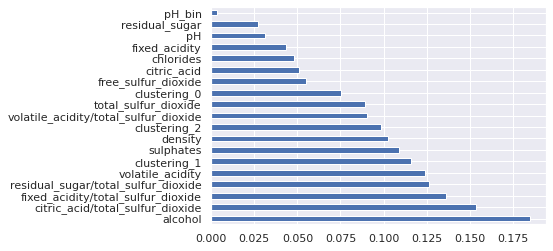

In [76]:
X = df_combined.drop('quality', axis=1)
y = df_combined['quality']
make_mi_scores(X, y).plot(kind='barh')

In [77]:
from sklearn.feature_selection import chi2, f_classif

In [78]:
f_classif(X, y)

(array([  6.91458108,  62.79061544,  22.21089643,   1.57214116,
         14.55101421,   5.30162458,  23.56688246,  12.71921685,
          5.91362699,  49.94095732, 119.23816213,  24.95138848,
         12.29301705,  28.66168772,  26.27896337,   3.7148296 ,
          6.21175882,   3.25506828,   3.99363981]),
 array([2.15648729e-006, 1.34543073e-059, 1.55616997e-021, 1.64810261e-001,
        5.98284903e-014, 7.79132992e-005, 7.22769695e-023, 3.96556140e-012,
        2.01496381e-005, 5.72175811e-048, 2.01360590e-106, 3.17428596e-024,
        1.05190749e-011, 7.65642818e-028, 1.59890780e-025, 2.40238948e-003,
        1.03832519e-005, 6.28480932e-003, 1.32951204e-003]))

In [79]:
scaled = StandardScaler().fit_transform(X)


In [80]:
scaled.var().sort_values()

AttributeError: 'numpy.float64' object has no attribute 'sort_values'

In [ ]:
import  math
from collections import Counter
def conditional_entropy(x,
                        y,
                        log_base: float = math.e):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy


In [ ]:



def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
theils_u(X['clustering_0'], y)